# Práctica 3 Caracterización y Clasificación de Texturas

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import pi
from skimage.feature import graycomatrix, graycoprops
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from os import listdir
from os.path import isfile, join
import cv2
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_rows', None, 'display.max_columns', None)

## Lectura de imágenes

Cargamos los nombres de las imágenes de entrenamiento y de validación:

In [2]:
mypath_ent = 'Entrenamiento/'
mypath_val = 'Validacion/'

onlyfiles_ent = [f for f in listdir(mypath_ent) if isfile(join(mypath_ent, f))]
onlyfiles_val = [f for f in listdir(mypath_val) if isfile(join(mypath_val, f))]

print('Nombres imagenes de entrenamiento:')
print(onlyfiles_ent,'\n')
print('Nombres imagenes de validación:')
print(onlyfiles_val)

Nombres imagenes de entrenamiento:
['1.bmp', '2.bmp', '3.bmp', '4.bmp', '5.bmp', '6.bmp', '7.jpg'] 

Nombres imagenes de validación:
['imgCompuesta1.png', 'imgCompuesta2.png', 'imgCompuesta3.png']


Los nombres de cada imafen indican la etiqueta o clase a la que pertenecen (previamente etiquetadas a mano) y el formato de la imágen.

Amacenamos todas las imagenes de entrenamiento en una lista 'Ient´

In [3]:
Ient = []
Ival = []
for file_ent in onlyfiles_ent:
    Ient.append(cv2.imread(mypath_ent+file_ent))
for file_val in onlyfiles_val:
    Ival.append(cv2.imread(mypath_val+file_val))

## Visualización de imágenes

### Imágenes de entrenamiento

Chequemos cuantos canales, de que tamaño y que tipo de dato tienen las imágenes:

In [4]:
for i,img in enumerate(Ient):
    print("Nombre: ", onlyfiles_ent[i], " tamaño:", img.shape, ' tipo de dato:', img.dtype.name)

Nombre:  1.bmp  tamaño: (640, 640, 3)  tipo de dato: uint8
Nombre:  2.bmp  tamaño: (640, 640, 3)  tipo de dato: uint8
Nombre:  3.bmp  tamaño: (640, 640, 3)  tipo de dato: uint8
Nombre:  4.bmp  tamaño: (640, 640, 3)  tipo de dato: uint8
Nombre:  5.bmp  tamaño: (640, 640, 3)  tipo de dato: uint8
Nombre:  6.bmp  tamaño: (640, 640, 3)  tipo de dato: uint8
Nombre:  7.jpg  tamaño: (641, 641, 3)  tipo de dato: uint8


Visualizamos las imágenes de entrenamiento:

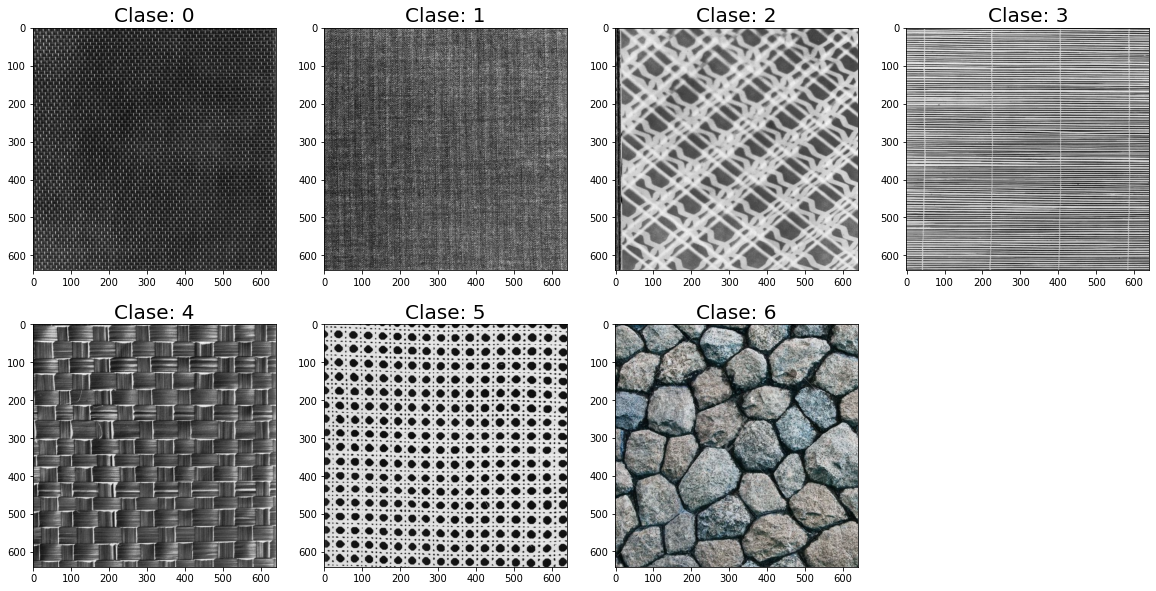

In [5]:
plt.figure(figsize=(20,10))
for i,img in enumerate(Ient):
    plt.subplot(2,4,i+1)
    plt.title("Clase: "+str(i),fontsize='20')
    plt.imshow(img,cmap='gray')
plt.savefig('texturas.png')

### Imagenes de validación

Chequemos cuantos canales, de que tamaño y que tipo de dato tienen las imágenes:

In [6]:
for i,img in enumerate(Ival):
    print("Nombre: ", onlyfiles_val[i], " tamaño:", img.shape, ' tipo de dato:', img.dtype.name)

Nombre:  imgCompuesta1.png  tamaño: (320, 320, 3)  tipo de dato: uint8
Nombre:  imgCompuesta2.png  tamaño: (320, 320, 3)  tipo de dato: uint8
Nombre:  imgCompuesta3.png  tamaño: (320, 320, 3)  tipo de dato: uint8


Visualizamos las imágenes de entrenamiento:

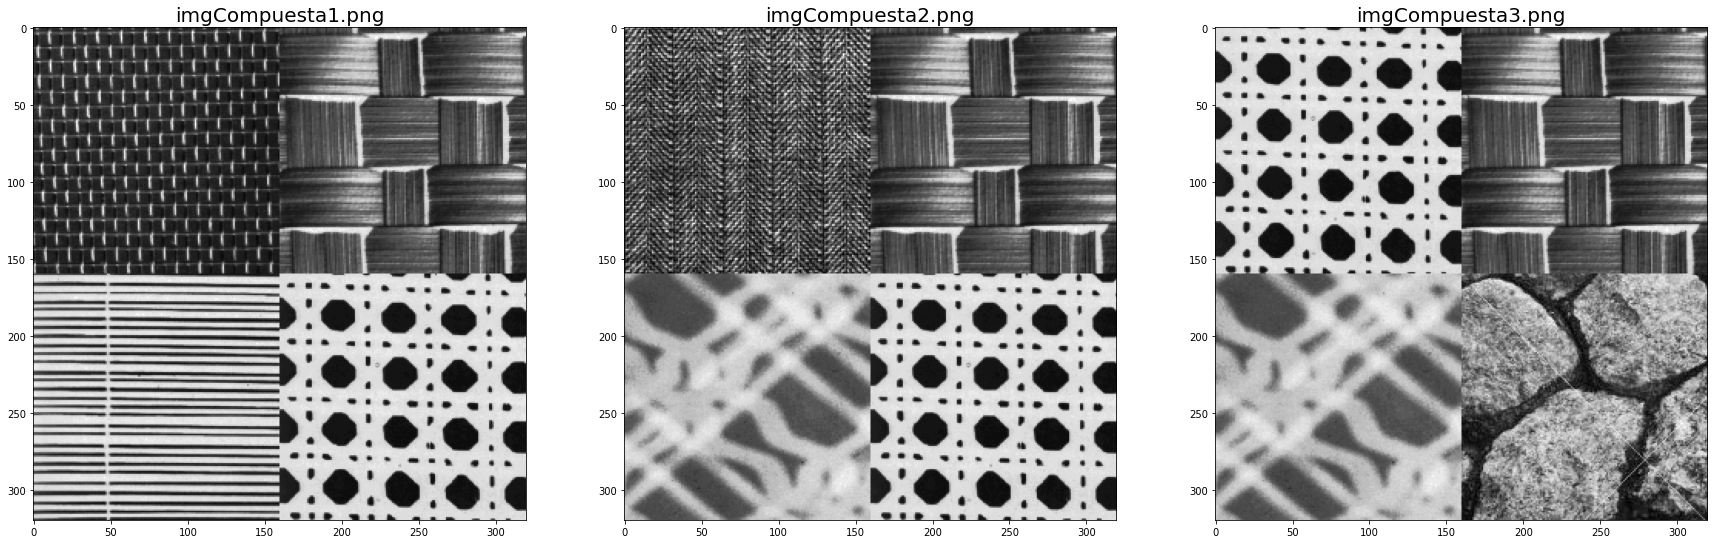

In [7]:
plt.figure(figsize=(30,10))
for i,img in enumerate(Ival):
    plt.subplot(1,3,i+1)
    plt.title(onlyfiles_val[i],fontsize='20')
    plt.imshow(img)

### Preprocesamiento de la imagen

Cambiamos las imágenes a escala de grises:

In [8]:
Ival = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in Ival]
Ient = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in Ient]

La última imágen le quitamos una fila y una columna para homogeneizar el tamaño de las imágenes.

In [9]:
Ient[-1] = Ient[-1][:-1,:-1]

In [10]:
for i,img in enumerate(Ient):
    print("Nombre: ", onlyfiles_ent[i], " tamaño:", img.shape, ' tipo de dato:', img.dtype.name)

Nombre:  1.bmp  tamaño: (640, 640)  tipo de dato: uint8
Nombre:  2.bmp  tamaño: (640, 640)  tipo de dato: uint8
Nombre:  3.bmp  tamaño: (640, 640)  tipo de dato: uint8
Nombre:  4.bmp  tamaño: (640, 640)  tipo de dato: uint8
Nombre:  5.bmp  tamaño: (640, 640)  tipo de dato: uint8
Nombre:  6.bmp  tamaño: (640, 640)  tipo de dato: uint8
Nombre:  7.jpg  tamaño: (640, 640)  tipo de dato: uint8


## Ventaneo de la imagen

Tomaremos ventanas de que consideren al menos un texel: provemos con $160 \times 160$

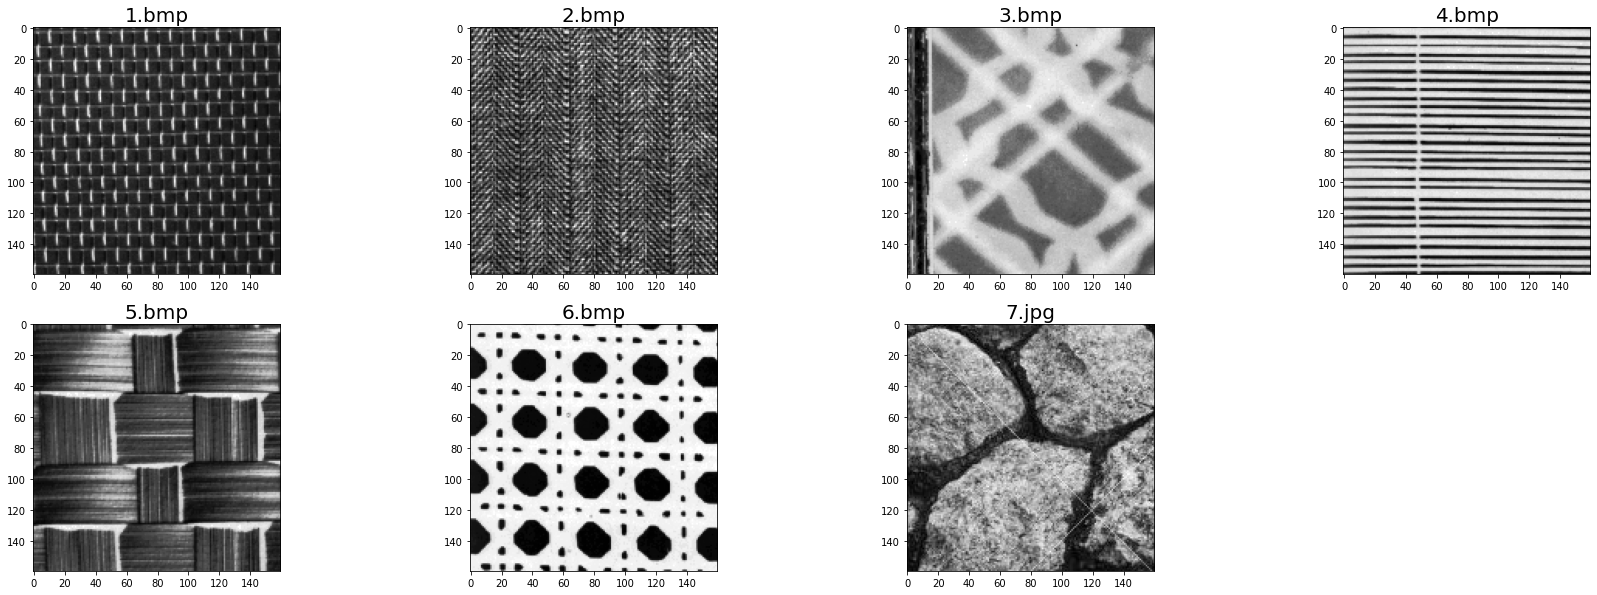

In [11]:
plt.figure(figsize=(30,10))
for i,img in enumerate(Ient):
    plt.subplot(2,4,i+1)
    plt.title(onlyfiles_ent[i],fontsize='20')
    plt.imshow(Ient[i][:160,:160],cmap='gray')

Para tenes distintos vectores de entrada por cada imagen haremos ventaneos traslapados, recorreremos la ventana cada $\Delta p$ pixeles tanto de manera horizontal como vertical.

In [12]:
vent_n = 160 #tamaño de ventana
dp = 21 # desplazamiento de ventana
num_ventx = ((Ient[0].shape[0]-vent_n)/dp) # Numero de ventanas en x
num_ventx 

22.857142857142858

Hagamos una prueba con una imagen cortada:

In [13]:
def ventaneo(img,lw=80,dp=80):
    num_ventx = ((img.shape[0]-lw)//dp)
    for j in range(num_ventx+1):
        for i in range(num_ventx+1):
            yield img[i*dp:i*dp+lw,j*dp:j*dp+lw]

Ventaneo con una imagen

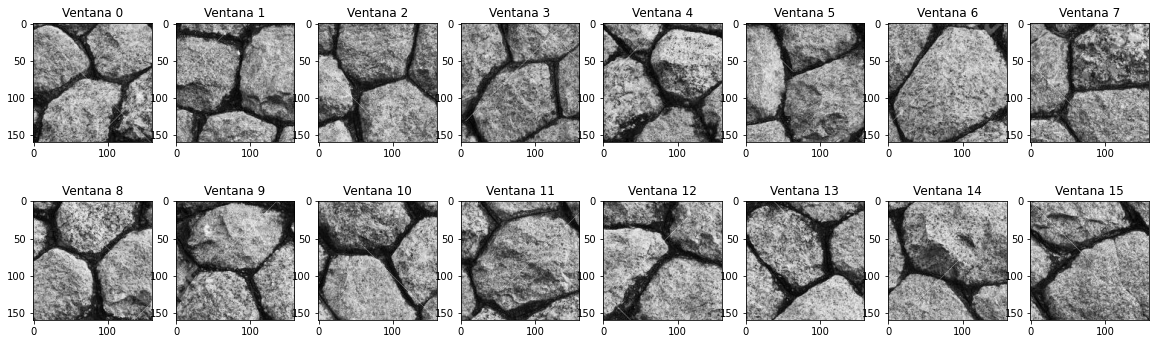

In [14]:
plt.figure(figsize=(20,6))
for i,vent in enumerate(ventaneo(Ient[6],lw=160,dp=160)):
    plt.subplot(2,8,i+1)
    plt.title('Ventana '+str(i))
    plt.imshow(vent,cmap='gray')
plt.savefig('ventaneo.png')

## Matriz GLCM

Calculamos 4 matrices GLCM, en cuatro direcciones diferentes ($\theta$) y con una distancia $d=1$

In [15]:
angulos = [0,pi/2,pi/4,3*pi/4]
distancia = [1]
GLCM=graycomatrix(vent,distancia,angulos,levels=256,symmetric=True) #Matriz de GLCM
GLCM.shape

(256, 256, 1, 4)

Obtenemos el tamaño de la matriz, a qué distancia se calculé y los 4 ángulos.

Cambiamos el tamaño de la matriz 

In [16]:
GLCM=GLCM.reshape((*GLCM.shape[0:2],len(angulos)))
GLCM.shape

(256, 256, 4)

Hacemos una función que calcula las matrices GLCM

In [17]:
def GLCM(ventana,d=[1],g = [0,pi/2,pi/4,3*pi/4], levels=256):
    return graycomatrix(ventana,distancia,angulos,levels,symmetric=True) #Matrices de GLCM

Visualizamos las matrices GLCM de una sola ventana

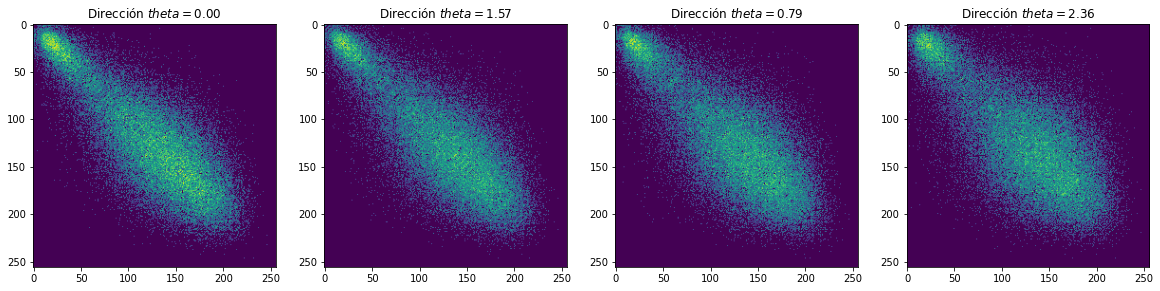

In [18]:
glcm=GLCM(vent)
plt.figure(figsize=(20,5))
for i in range(glcm.shape[-1]):
    plt.subplot(1,4,i+1)
    plt.title('Dirección $theta=${a:.2f}'.format(a=angulos[i]))
    plt.imshow(np.log(1+glcm[:,:,0,i])) #para poder visualizar calculamos log
plt.savefig('glcm.png')

## Extracción de características

Definimos una función para extraer características de, en este caso, 4 matrices GLCM, y regresar un vector de $1 \times $ (numeros de características $\times$ numero de matrices glcm)

In [19]:
def ext_carac(matriz, medidas=['homogeneity', 'energy', 'correlation']):
    n=matriz.shape[-1]
    carac = np.zeros(n*len(medidas))
    for i,medida in enumerate(medidas):
        carac[i*n:(i+1)*n] = graycoprops(matriz, medida)
    return carac

Por ejemplo, para las matrices $GLCM$ de una ventana se tiene:

In [20]:
a=[GLCM(vent) for vent in ventaneo(Ient[0][:30,:30],lw=10,dp=10)]
ext_carac(a[4])

array([0.15926569, 0.15516204, 0.1180239 , 0.10759988, 0.10540926,
       0.09493337, 0.10655973, 0.09876543, 0.48678266, 0.72067858,
       0.26605914, 0.33100964])

## Conjunto de entrenamiento

Para una imagen obtenemos el vector de características de todas las ventanas:

In [21]:
def carac_ventanas(img, lw=160, dp=20, d=[1], g = [0,pi/2,pi/4,3*pi/4], levels=256, medidas=['homogeneity', 'energy', 'correlation']):
    return np.array([ext_carac(GLCM(vent, d, g , levels),medidas) for vent in ventaneo(img,lw,dp)])

In [22]:
ext_carac(a[1],medidas=['homogeneity', 'energy', 'correlation'])

array([0.12522627, 0.20161858, 0.13841904, 0.09755778, 0.12095301,
       0.12247449, 0.11145352, 0.10329136, 0.50668637, 0.87091648,
       0.41818257, 0.41570292])

Observemos que con una con $\Delta p = 60$ obtenemos 64 vectores por cada imagen:

Definimos una función

In [23]:
def ext_carac_imgs(imagenes,lw=[80,80,160,160,160,80,160], dp=[80,80,160,160,160,80,160], d=[1], g = [0,pi/2,pi/4,3*pi/4], levels=256, medidas=['homogeneity', 'energy', 'correlation']):
    Xent = []
    for i, img in enumerate(imagenes):
        X = carac_ventanas(img,lw[i],dp[i],d,g,levels,medidas)
        Y = i*np.ones((X.shape[0],1))
        A = np.concatenate( (X,Y), axis=1 )
        Xent.append(A) 
    return Xent

### Data Frame del conjunto de entrenamiento

Realizamos un data frame del conjunto de entrenamiento

In [24]:
X=ext_carac_imgs(Ient)

In [25]:
data_ent = []
data_val = []
for i,j in zip(range(7),[32,32,8,8,8,32,8]):
    data_ent.append(X[i][:j])
    data_val.append(X[i][j:])

In [26]:
Xent = np.concatenate((data_ent[0],data_ent[1]))
Xval = np.concatenate((data_val[0],data_val[1]))
for i in [2,3,4,5,6]:
    Xent = np.concatenate((Xent,data_ent[i]))
    Xval = np.concatenate((Xval,data_val[i]))

In [27]:
df_ent=pd.DataFrame(Xent)
df_ent.head()

0         1         2         3         4         5         6   \
0  0.188222  0.213456  0.127097  0.117417  0.078517  0.081108  0.067376   
1  0.184954  0.204603  0.115636  0.124014  0.062256  0.066475  0.053110   
2  0.173750  0.191418  0.109340  0.105914  0.059368  0.060670  0.051008   
3  0.189532  0.212682  0.120096  0.123050  0.065598  0.068213  0.056112   
4  0.183615  0.196974  0.121251  0.114497  0.065776  0.068767  0.057142   

         7         8         9         10        11   12  
0  0.065136  0.496741  0.820759  0.380107  0.363572  0.0  
1  0.052091  0.479652  0.834763  0.376129  0.352576  0.0  
2  0.049549  0.464248  0.829130  0.350951  0.336063  0.0  
3  0.055173  0.478519  0.834830  0.377859  0.351409  0.0  
4  0.055458  0.457830  0.846283  0.366738  0.334680  0.0

In [28]:
df_val=pd.DataFrame(Xval)
df_val.head()

0         1         2         3         4         5         6   \
0  0.233403  0.253114  0.161910  0.153959  0.088432  0.092920  0.076699   
1  0.268817  0.291950  0.199436  0.191537  0.111489  0.115963  0.097414   
2  0.258284  0.286592  0.188752  0.181312  0.107305  0.113395  0.094725   
3  0.213778  0.237655  0.144737  0.141544  0.072259  0.077516  0.063272   
4  0.203560  0.238904  0.138417  0.139237  0.070379  0.075710  0.061232   

         7         8         9         10        11   12  
0  0.075200  0.466891  0.829959  0.326056  0.361696  0.0  
1  0.092948  0.485319  0.807878  0.333632  0.356085  0.0  
2  0.091475  0.457598  0.833331  0.321821  0.356442  0.0  
3  0.061519  0.472362  0.832689  0.337116  0.376459  0.0  
4  0.060035  0.472859  0.860932  0.362880  0.394562  0.0

## Clasificador bayesiano

## Entrenamiento en datos ordenados

Entrenamos el modelo con los datos


In [29]:
gnb = GaussianNB()
gnb.fit(Xent[:,:-1], Xent[:,-1])

GaussianNB()

Realizamos las predicciones de entrenamiento y validación

In [30]:
ypred_ent=gnb.predict(Xent[:,:-1])
ypred_val=gnb.predict(Xval[:,:-1])

Visualizamos las clases verdaderas del conjunto de entrenamiento

In [31]:
Xent[:,-1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2.,
       2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 4., 4., 4., 4., 4.,
       4., 4., 4., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 6., 6., 6., 6., 6., 6., 6., 6.])

Visualizamos las clases predichas del conjunto de entrenamiento 

In [32]:
ypred_ent

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2.,
       2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 4., 4., 4., 4., 4.,
       4., 4., 4., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 6., 6., 6., 6., 6., 6., 6., 6.])

Visualizamos las clases verdaderas del conjunto de validación

In [33]:
Xval[:,-1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2.,
       2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 4., 4., 4., 4., 4.,
       4., 4., 4., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 6., 6., 6., 6., 6., 6., 6., 6.])

Ahora las clases predichas del conjunto de validación

In [34]:
ypred_val

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2.,
       2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 4., 4., 4., 4., 4.,
       4., 4., 4., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 6., 6., 6., 6., 6., 6., 6., 6.])

## Entrenamiento de datos ordenados aleatoriamente

In [35]:
data = np.concatenate((X[0],X[1]))
for i in [2,3,4,5,6]:
    data = np.concatenate((data,X[i]))

Hacemos una partición de entrenamiento y validación

In [36]:
from sklearn.model_selection import train_test_split
X_ent, X_val, y_ent, y_val = train_test_split(data[:,:-1],data[:,-1],train_size=0.80, random_state=0)

Entrenamos el modelo

In [37]:
gnb = GaussianNB()
gnb.fit(X_ent, y_ent)
ypred_ent=gnb.predict(X_ent)
ypred_val=gnb.predict(X_val)

Checamos el score de entrenamiento y de validación

In [38]:
print(gnb.score(X_ent,y_ent),'  ',gnb.score(X_val,y_val))

1.0    1.0


Matriz de confusión

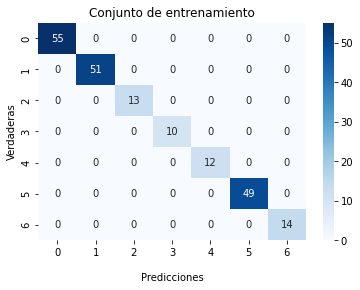

<Figure size 432x288 with 0 Axes>

In [39]:
ax = sns.heatmap(confusion_matrix(y_ent, ypred_ent), annot=True, cmap='Blues')
ax.set_title('Conjunto de entrenamiento');
ax.set_xlabel('\nPredicciones')
ax.set_ylabel('Verdaderas');
plt.show()
plt.savefig('mc_ent.png')

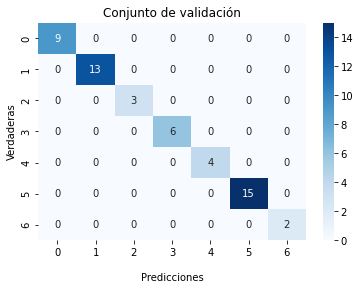

<Figure size 432x288 with 0 Axes>

In [40]:
ax = sns.heatmap(confusion_matrix(y_val, ypred_val), annot=True, cmap='Blues')
ax.set_title('Conjunto de validación');
ax.set_xlabel('\nPredicciones')
ax.set_ylabel('Verdaderas');
plt.show()
plt.savefig('mc_val.png')

## Probar en el conjunto de prueba

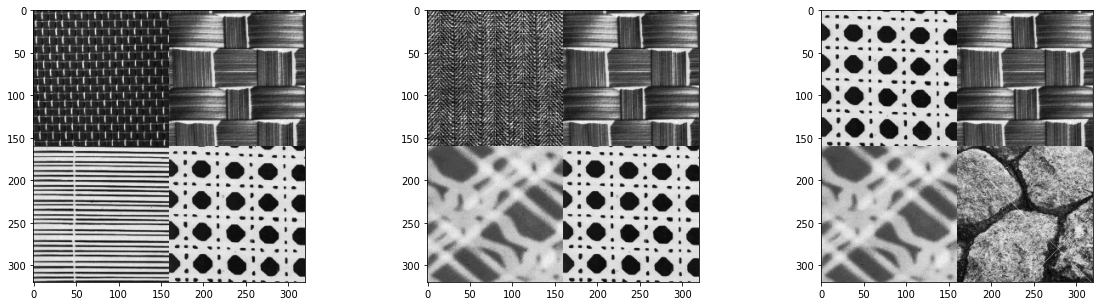

In [41]:
plt.figure(figsize=(20,5))
for i,img in enumerate(Ival):
    plt.subplot(1,3,i+1)
    plt.imshow(img,cmap='gray')

Las imagenes son de medidas

In [42]:
img.shape

(320, 320)

Hacemos 4 ventanas por imagen

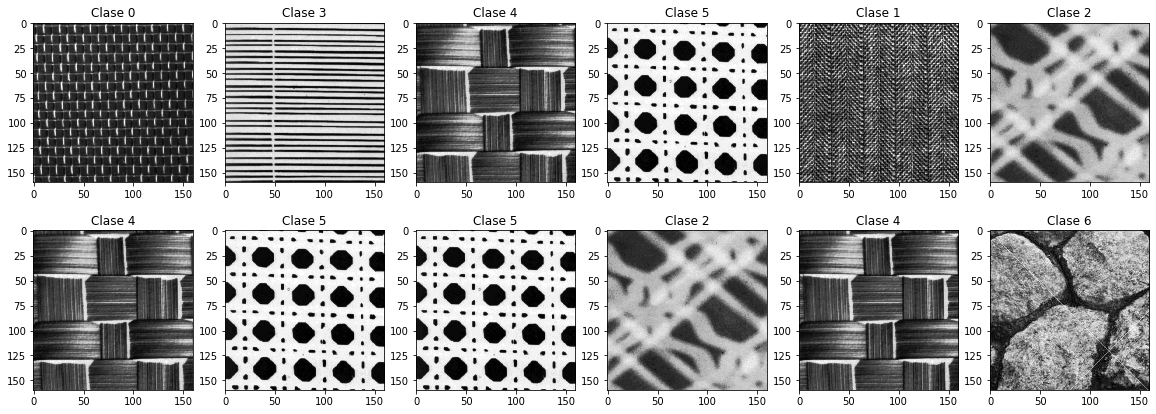

In [43]:
plt.figure(figsize=(20,7))
i=0
etiquetas = np.array([1,4,5,6,2,3,5,6,6,3,5,7])-1
for img in Ival:
    for vent in ventaneo(img,lw=int(img.shape[0]/2),dp=int(img.shape[0]/2)):
        plt.subplot(2,6,i+1)
        plt.title('Clase '+str(etiquetas[i]))
        plt.imshow(vent,cmap='gray')
        i+=1
plt.savefig('ventaneo_validacion.png')

Conjunto de prueba 

In [44]:
ventanas = []
for img in Ival:
    ventanas.append( [carac_ventanas(vent,lw=160,dp=160) for vent in ventaneo(img, lw=160, dp=160)] )
ventanas=[*ventanas[0],*ventanas[1],*ventanas[2]]

Extraer características

In [45]:
X_pru = np.concatenate((ventanas[0],ventanas[1]))
for i in range(12)[2:]:
    X_pru=np.concatenate((X_pru,ventanas[i]))

In [46]:
df_val = pd.DataFrame(X_pru)
df_val['12'] = etiquetas
df_val

0         1         2         3         4         5         6  \
0   0.199955  0.218693  0.131836  0.131972  0.060378  0.062849  0.049764   
1   0.465608  0.102094  0.100058  0.099198  0.138431  0.075746  0.075834   
2   0.210764  0.167106  0.096795  0.096267  0.042521  0.039457  0.029552   
3   0.430642  0.423244  0.382551  0.379954  0.196642  0.191620  0.181660   
4   0.035638  0.034277  0.033481  0.030434  0.018484  0.018468  0.017970   
5   0.231211  0.219761  0.207156  0.192512  0.053986  0.052897  0.050113   
6   0.210764  0.167106  0.096795  0.096267  0.042521  0.039457  0.029552   
7   0.430642  0.423244  0.382551  0.379954  0.196642  0.191620  0.181660   
8   0.430642  0.423244  0.382551  0.379954  0.196642  0.191620  0.181660   
9   0.231211  0.219761  0.207156  0.192512  0.053986  0.052897  0.050113   
10  0.210764  0.167106  0.096795  0.096267  0.042521  0.039457  0.029552   
11  0.044790  0.043249  0.039056  0.039938  0.008549  0.008471  0.008177   

           7         8         9        10        11  12  
0   0.049037  0.492236  0.835370  0.381380  0.373037   0  
1   0.074974  0.992998  0.385777  0.389796  0.375340   3  
2   0.029495  0.905715  0.849303  0.763126  0.771798   4  
3   0.179606  0.926068  0.917336  0.871795  0.860663   5  
4   0.018143  0.280781  0.244512 -0.021753  0.020371   1  
5   0.048626  0.979639  0.975758  0.969094  0.959512   2  
6   0.029495  0.905715  0.849303  0.763126  0.771798   4  
7   0.179606  0.926068  0.917336  0.871795  0.860663   5  
8   0.179606  0.926068  0.917336  0.871795  0.860663   5  
9   0.048626  0.979639  0.975758  0.969094  0.959512   2  
10  0.029495  0.905715  0.849303  0.763126  0.771798   4  
11  0.008166  0.837568  0.818134  0.778173  0.771232   6

Predicciones

In [47]:
X_pru=df_val.to_numpy()
y_pru=X_pru[:,-1]
X_pru=X_pru[:,:-1]
gnb.score(X_pru,y_pru)

1.0

## Clasificador SVM

Obtenemos conjunto de entrenamiento y validación

In [48]:
X_ent, X_val, y_ent, y_val = train_test_split(data[:,:-1],data[:,-1],train_size=0.80, random_state=0)

Entrenamos modelos y calculamos la precisión del conjunto de entrenamiento

In [72]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_ent,y_ent)
clf.score(X_ent,y_ent)

1.0

Precisión del conjunto de validación

In [50]:
clf.score(X_val,y_val)

1.0

Precisión del conjunto de prueba

In [51]:
clf.score(X_pru,y_pru)

1.0

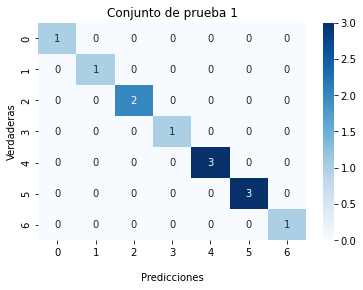

<Figure size 432x288 with 0 Axes>

In [52]:
ax = sns.heatmap(confusion_matrix(y_pru, clf.predict(X_pru)), annot=True, cmap='Blues')
ax.set_title('Conjunto de prueba 1');
ax.set_xlabel('\nPredicciones')
ax.set_ylabel('Verdaderas');
plt.show()
plt.savefig('mc_pru1.png')

## Prueba con una imagen editada

Debido a que tuvimos una precisión perfecta, intentemos ahora con una imagen compuesta como se muestra a continuación

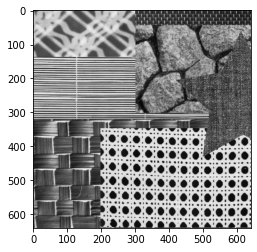

In [53]:
I=cv2.imread('g4822.png')
I=cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
plt.imshow(I,cmap='gray')

Utilizamos diferentes ventanas para cada una de ellas (de tamaño 160)

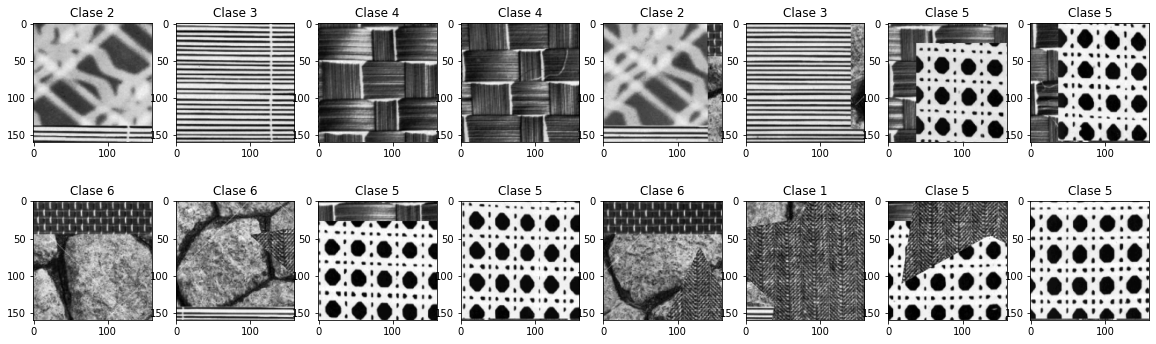

In [54]:
plt.figure(figsize=(20,6))
i=0
etiquetas = np.array([3,4,5,5,3,4,6,6,7,7,6,6,7,2,6,6])-1
for vent in ventaneo(I,lw=160, dp=160):
    plt.subplot(2,8,i+1)
    plt.title('Clase '+str(etiquetas[i]))
    plt.imshow(vent,cmap='gray')
    i+=1
plt.savefig('ventaneo_prueba.png')

Extraermos las características de cada ventana

In [55]:
Vcomp = ext_carac_imgs([I],lw=[160], dp=[160])
Vcomp = Vcomp[0]
Vcomp[:,-1] = etiquetas

Podemos visualizarlas así

In [56]:
pd.DataFrame(Vcomp)

0         1         2         3         4         5         6   \
0   0.251467  0.193750  0.176155  0.157700  0.027756  0.025134  0.022604   
1   0.429167  0.043615  0.042172  0.041050  0.038396  0.015587  0.015330   
2   0.208816  0.158214  0.086546  0.089549  0.021872  0.020254  0.015406   
3   0.189551  0.169685  0.082529  0.084204  0.022905  0.022097  0.016370   
4   0.227898  0.173917  0.148551  0.140881  0.023447  0.021351  0.018974   
5   0.409131  0.036091  0.034545  0.033739  0.032212  0.012541  0.012302   
6   0.297835  0.283958  0.219872  0.215991  0.059102  0.062513  0.052815   
7   0.318250  0.333466  0.259087  0.252293  0.082398  0.088840  0.072662   
8   0.097183  0.100142  0.065921  0.063461  0.012238  0.012629  0.010610   
9   0.109750  0.065373  0.051212  0.052587  0.011221  0.009931  0.009178   
10  0.309305  0.312935  0.244414  0.243541  0.067766  0.072791  0.059757   
11  0.373557  0.399226  0.328212  0.323421  0.112200  0.120547  0.101745   
12  0.095762  0.098385  0.065430  0.065795  0.013041  0.013267  0.011142   
13  0.050548  0.041608  0.036871  0.034082  0.010046  0.009964  0.009467   
14  0.208083  0.219064  0.174941  0.171422  0.047915  0.052012  0.043051   
15  0.343274  0.360328  0.291567  0.289071  0.093450  0.099617  0.083118   

          7         8         9         10        11   12  
0   0.021491  0.989653  0.890259  0.888007  0.876091  2.0  
1   0.015083  0.994626  0.521418  0.524049  0.511460  3.0  
2   0.015514  0.935097  0.893091  0.832832  0.840915  4.0  
3   0.016492  0.873283  0.871161  0.755678  0.762597  4.0  
4   0.018355  0.974716  0.899097  0.880093  0.875225  2.0  
5   0.012194  0.992374  0.562900  0.558240  0.556157  3.0  
6   0.052016  0.941062  0.940672  0.892483  0.888287  5.0  
7   0.071775  0.936585  0.950849  0.900754  0.891982  5.0  
8   0.010445  0.902090  0.936795  0.867818  0.856659  6.0  
9   0.009215  0.916605  0.799995  0.747901  0.755593  6.0  
10  0.059706  0.938444  0.944811  0.894654  0.889584  5.0  
11  0.101096  0.929284  0.949589  0.891171  0.885992  5.0  
12  0.011046  0.856963  0.889850  0.788695  0.790823  6.0  
13  0.009508  0.662131  0.611891  0.431841  0.456021  1.0  
14  0.042256  0.909822  0.925323  0.855785  0.867349  5.0  
15  0.082931  0.929625  0.944649  0.883666  0.885406  5.0

Clases verdaderas

In [57]:
Vcomp[:,-1]

array([2., 3., 4., 4., 2., 3., 5., 5., 6., 6., 5., 5., 6., 1., 5., 5.])

Clases predichas con clasificador bayesiano ingenuo:

In [58]:
gnb.predict(Vcomp[:,:-1])

array([4., 3., 4., 4., 4., 3., 2., 5., 4., 6., 2., 5., 4., 0., 2., 5.])

Precisión obtenida con el clasificador bayesiano ingenuo 

In [59]:
gnb.score(Vcomp[:,:-1],Vcomp[:,-1])

0.5

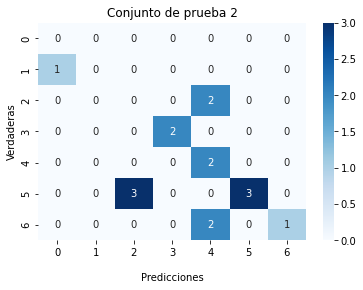

<Figure size 432x288 with 0 Axes>

In [60]:
ax = sns.heatmap(confusion_matrix(Vcomp[:,-1], gnb.predict(Vcomp[:,:-1])), annot=True, cmap='Blues')
ax.set_title('Conjunto de prueba 2');
ax.set_xlabel('\nPredicciones')
ax.set_ylabel('Verdaderas');
plt.show()
plt.savefig('mcGNB_pru2.png')

Clases predichas con el modelo VSM

In [61]:
clf.predict(Vcomp[:,:-1])

array([2., 3., 4., 4., 4., 3., 2., 2., 6., 6., 2., 5., 6., 6., 2., 2.])

Precisión obtenida con VSM

In [62]:
Vcomp[:,-1]

array([2., 3., 4., 4., 2., 3., 5., 5., 6., 6., 5., 5., 6., 1., 5., 5.])

In [63]:
clf.score(Vcomp[:,:-1],Vcomp[:,-1])

0.5625

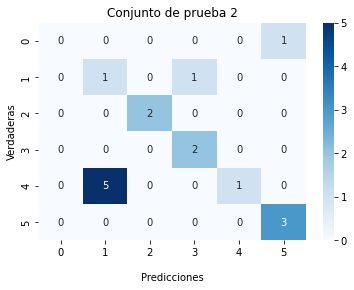

<Figure size 432x288 with 0 Axes>

In [73]:
ax = sns.heatmap(confusion_matrix(Vcomp[:,-1], clf.predict(Vcomp[:,:-1])), annot=True, cmap='Blues')
ax.set_title('Conjunto de prueba 2');
ax.set_xlabel('\nPredicciones')
ax.set_ylabel('Verdaderas');
plt.show()
plt.savefig('mcGNB_pru2.png')

In [70]:
clf.classes_

array([0., 1., 2., 3., 4., 5., 6.])

In [65]:
Vcomp[:,-1]

array([2., 3., 4., 4., 2., 3., 5., 5., 6., 6., 5., 5., 6., 1., 5., 5.])

In [66]:
clf.predict(Vcomp[:,:-1])

array([2., 3., 4., 4., 4., 3., 2., 2., 6., 6., 2., 5., 6., 6., 2., 2.])

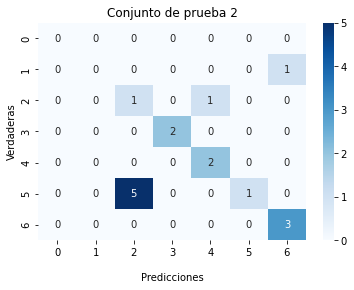

<Figure size 432x288 with 0 Axes>

In [79]:
ax = sns.heatmap(confusion_matrix([2., 3., 4., 4., 2., 3., 5., 5., 6., 6., 5., 5., 6., 1., 5., 5.], [2., 3., 4., 4., 4., 3., 2., 2., 6., 6., 2., 5., 6., 6., 2., 2.], labels=range(7)), annot=True, cmap='Blues')
ax.set_title('Conjunto de prueba 2')
ax.set_xlabel('\nPredicciones')
ax.set_ylabel('Verdaderas');
plt.show()
plt.savefig('mcGNB_pru2.png')

## Selección de características

Con clasificador bayesiano ingenuo

In [67]:
medidas=['homogeneity', 'energy', 'correlation']# 0 1 2
clases = Xent[:,-1]
for att in [[0,3,6,9],[1,4,7,10],[2,5,8,11],[0,3,6,9,1,4,7,10],range(12)]:
    X = Xent[:,np.array(att)]
    gnb.fit(X, clases)
    print('\nIndices de atributos: ',att,)
    print("Score en cjto de entrenamiento", gnb.score(X,clases))
    print("Score en cjto de validacion", gnb.score(X_val[:,np.array(att)],y_val))
    print("Score en cjto de prueba2", gnb.score(Vcomp[:,np.array(att)],Vcomp[:,-1]))


Indices de atributos:  [0, 3, 6, 9]
Score en cjto de entrenamiento 1.0
Score en cjto de validacion 1.0
Score en cjto de prueba2 0.25

Indices de atributos:  [1, 4, 7, 10]
Score en cjto de entrenamiento 1.0
Score en cjto de validacion 1.0
Score en cjto de prueba2 0.5625

Indices de atributos:  [2, 5, 8, 11]
Score en cjto de entrenamiento 1.0
Score en cjto de validacion 1.0
Score en cjto de prueba2 0.5

Indices de atributos:  [0, 3, 6, 9, 1, 4, 7, 10]
Score en cjto de entrenamiento 1.0
Score en cjto de validacion 1.0
Score en cjto de prueba2 0.5625

Indices de atributos:  range(0, 12)
Score en cjto de entrenamiento 1.0
Score en cjto de validacion 1.0
Score en cjto de prueba2 0.625


Con SVM

In [68]:
medidas=['homogeneity', 'energy', 'correlation']# 0 1 2
clases = Xent[:,-1]
for att in [[0,3,6,9],[1,4,7,10],[2,5,8,11],[0,3,6,9,1,4,7,10],range(12)]:
    X = Xent[:,np.array(att)]
    clf.fit(X, clases)
    print('\nIndices de atributos: ',att,)
    print("Score en cjto de entrenamiento", clf.score(X,clases))
    print("Score en cjto de validacion", clf.score(X_val[:,np.array(att)],y_val))
    print("Score en cjto de prueba2", clf.score(Vcomp[:,np.array(att)],Vcomp[:,-1]))


Indices de atributos:  [0, 3, 6, 9]
Score en cjto de entrenamiento 0.9375
Score en cjto de validacion 0.9230769230769231
Score en cjto de prueba2 0.375

Indices de atributos:  [1, 4, 7, 10]
Score en cjto de entrenamiento 1.0
Score en cjto de validacion 1.0
Score en cjto de prueba2 0.4375

Indices de atributos:  [2, 5, 8, 11]
Score en cjto de entrenamiento 1.0
Score en cjto de validacion 1.0
Score en cjto de prueba2 0.5

Indices de atributos:  [0, 3, 6, 9, 1, 4, 7, 10]
Score en cjto de entrenamiento 1.0
Score en cjto de validacion 1.0
Score en cjto de prueba2 0.5625

Indices de atributos:  range(0, 12)
Score en cjto de entrenamiento 1.0
Score en cjto de validacion 1.0
Score en cjto de prueba2 0.625
